<a href="https://colab.research.google.com/github/CristinaMarsh/Reproduce/blob/main/TimeSeries/DILATE_DIstortion_Loss_with_shApe_and_tImE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/vincent-leguen/DILATE.git

Cloning into 'DILATE'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 69 (delta 6), reused 1 (delta 0), pack-reused 52
Unpacking objects: 100% (69/69), done.


# Seq2seq

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderRNN(torch.nn.Module):
    '''
    arg:
    input_size: feature
    hidden_size: units
    layers: stack number
    batch_size:
    device: cuda

    input: input (batch_size, length T, dimensionality d), hidden
    output: output, hidden
    '''
    
    def __init__(self, input_size, hidden_size, num_grulstm_layers, batch_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_grulstm_layers = num_grulstm_layers
        self.batch_size = batch_size
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_grulstm_layers, batch_first = True)

    def forward(self, input, hidden): #input: (batch_size, length T, dimensionality d)
        output, hidden = self.gru(input, hidden)
        return output, hidden #(B, L, H) (N, B, H)
      
    def init_hidden(self,device):
      #num_layer, B, Hidden_size
      return torch.zeros(self.num_grulstm_layers, self.batch_size, self.hidden_size, device=device) # initial parameter and put it into device

class DecoderRNN(nn.Module):

    '''
    arg:
    input_size: feature
    hidden_size: units
    layers: stack number
    fc_units: for prediction
    output_size: for prediction

    input: 
    input (batch_size, length T, dimensionality d), hidden
    output: output, hidden
    '''  

    def __init__(self, input_size, hidden_size, num_grulstm_layers, fc_units, output_size):
        super(DecoderRNN, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers = num_grulstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, fc_units)
        self.out = nn.Linear(fc_units, output_size)

    def forward(self, input, hidden):
      output, hidden = self.gru(input, hidden) #(B, L, H) (N, B, H)
      output = F.relu(self.fc(output))
      output = self.out(output)
      return output, hidden ##  (B, L, outsize)√
    
class Net_GRU(nn.Module):

    def __init__(self, encoder, decoder, target_length, device):
      super(Net_GRU, self).__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.target_length = target_length
      self.device = device

    def forward(self, x):
      input_length = x.shape[1] #seq_len
      encoder_hidden = self.encoder.init_hidden(self.device) # num_layer, B, Hidden
      for ei in range(input_length): # For L(sequence length)
        #ei:ei+1 1 step
        encoder_output, encoder_hidden = self.encoder(x[:, ei:ei+1, :], encoder_hidden) #

      decoder_input = x[:,-1,:].unsqueeze(1) # first decoder input= last element of input sequence
      decoder_hidden = encoder_hidden

      outputs = torch.zeros([x.shape[0], self.target_length, x.shape[2]]) #multi step prediction
      for di in range(self.target_length):
        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden) # each time step decoder #could error?
        outputs[:,di:di+1,:] = decoder_output
      return outputs


In [ ]:
class Net_GRU(nn.Module):

    def __init__(self, encoder, decoder, target_length, device):
      super(Net_GRU, self).__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.target_length = target_length
      self.device = device

    def forward(self, x):
      input_length = x.shape[1] #seq_len
      encoder_hidden = self.encoder.init_hidden(self.device)
      for ei in range(input_length):
        #ei:ei+1 1 step
        encoder_output, encoder_hidden = self.encoder(x[:, ei:ei+1, :], encoder_hidden)

      decoder_input = x[:,-1,:].unsqueeze(1) # first decoder input= last element of input sequence
      decoder_hidden = encoder_hidden

      outputs = torch.zeros([x.shape[0], self.target_length, x.shape[2]]) #multi step prediction
      for di in range(self.target_length):
        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
        outputs[:,di:di+1,:] = decoder_output
      return outputs

In [ ]:
class Net_GRU(nn.Module):
    def __init__(self, encoder, decoder, target_length, device):
        super(Net_GRU, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_length = target_length
        self.device = device
        
    def forward(self, x):
        input_length  = x.shape[1]
        encoder_hidden = self.encoder.init_hidden(self.device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(x[:,ei:ei+1,:]  , encoder_hidden) #x[:,ei:ei+1,:]  = (B, 1, F) L = 1, output = B, 1, H
            
        decoder_input = x[:,-1,:].unsqueeze(1) # first decoder input= last element of input sequence #(B, 1, F(input_size))
        decoder_hidden = encoder_hidden #Number_layer, B, Hidden_size
        
        outputs = torch.zeros([x.shape[0], self.target_length, x.shape[2]] ).to(self.device) # B, predict_len, F
        for di in range(self.target_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden) 
            decoder_input = decoder_output #(B, L, outsize)
            outputs[:,di:di+1,:] = decoder_output 
        return outputs #torch.Size([100, 20, 1]) B, predict, outsize

## Check

In [ ]:
class DecoderRNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_grulstm_layers, fc_units, output_size):
        super(DecoderRNN, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers = num_grulstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, fc_units)
        self.out = nn.Linear(fc_units, output_size)

    def forward(self, input, hidden):
      output, hidden = self.gru(input, hidden) #(B, L, H) (N, B, H)
      output = F.relu(self.fc(output)) # #(B, L, H) --> (B, L, Fc)
      print(f'first FC {output.size()}') # (B, L, Fc) √
      output = self.out(output)# (B, L, Fc) --> (B, L, 1)
      print(f'second FC {output.size()}') #  (B, L, 1)√
      return output, hidden

In [ ]:
input_size = 3
hidden_size = 64
num_grulstm_layers, fc_units, output_size = 2, 512, 1

dec = DecoderRNN(3,64,2,512,1)
x_test = torch.randn(32, 12, 3)
hidden = torch.zeros(2, 32, 64)
output, hidden = dec(x_test,hidden) #(32(B), 12(T), 1(Out_size))  (2(layer), 32(B), 64(H))

first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])


In [ ]:
x_test[:, 1:2, :].shape

torch.Size([32, 1, 3])

In [ ]:
x_test[:, -1, :].shape

torch.Size([32, 3])

In [ ]:
target_length = 7
outputs = torch.zeros([x_test.shape[0], target_length, x_test.shape[2]])
for di in range(target_length):
  output, hidden = dec(x_test,hidden) #([32, 12, 1]) (B, L, out_size)
  print(output.size())

first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])
torch.Size([32, 12, 1])
first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])
torch.Size([32, 12, 1])
first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])
torch.Size([32, 12, 1])
first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])
torch.Size([32, 12, 1])
first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])
torch.Size([32, 12, 1])
first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])
torch.Size([32, 12, 1])
first FC torch.Size([32, 12, 512])
second FC torch.Size([32, 12, 1])
torch.Size([32, 12, 1])


In [ ]:
#Original code

import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderRNN(torch.nn.Module):
    def __init__(self,input_size, hidden_size, num_grulstm_layers, batch_size):
        super(EncoderRNN, self).__init__()  
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_grulstm_layers = num_grulstm_layers
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_grulstm_layers,batch_first=True)

    def forward(self, input, hidden): # input [batch_size, length T, dimensionality d]      
        output, hidden = self.gru(input, hidden)      
        return output, hidden
    
    def init_hidden(self,device):
        #[num_layers*num_directions,batch,hidden_size]   
        return torch.zeros(self.num_grulstm_layers, self.batch_size, self.hidden_size, device=device)
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_grulstm_layers,fc_units, output_size):
        super(DecoderRNN, self).__init__()      
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_grulstm_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, fc_units)
        self.out = nn.Linear(fc_units, output_size)         
        
    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden) 
        output = F.relu( self.fc(output) )
        output = self.out(output)      
        return output, hidden
    
class Net_GRU(nn.Module):
    def __init__(self, encoder, decoder, target_length, device):
        super(Net_GRU, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.target_length = target_length
        self.device = device
        
    def forward(self, x):
        input_length  = x.shape[1]
        encoder_hidden = self.encoder.init_hidden(self.device)
        for ei in range(input_length):
            encoder_output, encoder_hidden = self.encoder(x[:,ei:ei+1,:]  , encoder_hidden)
            
        decoder_input = x[:,-1,:].unsqueeze(1) # first decoder input= last element of input sequence
        decoder_hidden = encoder_hidden
        
        outputs = torch.zeros([x.shape[0], self.target_length, x.shape[2]]  ).to(self.device)
        for di in range(self.target_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            decoder_input = decoder_output
            outputs[:,di:di+1,:] = decoder_output
        return outputs      

## Data


In [2]:
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader

In [3]:
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader

def create_synthetic_dataset(N, N_input,N_output,sigma):
    # N: number of samples in each split (train, test)
    # N_input: import of time steps in input series
    # N_output: import of time steps in output series
    # sigma: standard deviation of additional noise
    X = []
    breakpoints = []
    for k in range(2*N):
        serie = np.array([ sigma*random.random() for i in range(N_input+N_output)])
        i1 = random.randint(1,10)
        i2 = random.randint(10,18)
        j1 = random.random()
        j2 = random.random()
        interval = abs(i2-i1) + random.randint(-3,3)
        serie[i1:i1+1] += j1
        serie[i2:i2+1] += j2
        serie[i2+interval:] += (j2-j1)
        X.append(serie)
        breakpoints.append(i2+interval)
    X = np.stack(X)
    breakpoints = np.array(breakpoints)
    return X[0:N,0:N_input], X[0:N, N_input:N_input+N_output], X[N:2*N,0:N_input], X[N:2*N, N_input:N_input+N_output],breakpoints[0:N], breakpoints[N:2*N]

In [ ]:
class SyntheticDataset(torch.utils.data.Dataset):
  
    def __init__(self, X_input, X_target, breakpoint):
      self.X_input = X_input
      self.X_target = X_target
      self.breakpoint = breakpoint

    def __len__(self):
      return (self.X_input).shape[0]

    def __getitem__(self, idx):
      return (self.X_input[idx, :, np.newaxis]) #(idx)?batch?

In [4]:
a = torch.randn(64, 32, 10)
a[1:,:,np.newaxis].shape

torch.Size([63, 32, 1, 10])

## Training

In [5]:
%cd DILATE/

/content/DILATE


In [8]:
import sys

import numpy as np
import torch 
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import random
import warnings
import warnings; warnings.simplefilter('ignore')

try:
  import tslearn
except ModuleNotFoundError:
  !pip install tslearn

from tslearn.metrics import dtw, dtw_path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.1 MB/s 


In [10]:
from data.synthetic_dataset import create_synthetic_dataset, SyntheticDataset
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from loss.dilate_loss import dilate_loss

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random.seed(0)

# parameters
batch_size = 100
N = 500
N_input = 20
N_output = 20  
sigma = 0.01
gamma = 0.01

# Load synthetic dataset
X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)



In [16]:
[i.shape for i in next(iter(trainloader))]

[torch.Size([100, 20, 1]), torch.Size([100, 20, 1]), torch.Size([100])]

In [40]:
[i.shape for i in next(iter(testloader))]

[torch.Size([100, 20, 1]), torch.Size([100, 20, 1]), torch.Size([100])]

In [17]:
for i, data in enumerate(trainloader, 0):
  input, target, _ = data #input: Tensor with shape torch.Size([100, 20, 1]) target: Tensor with shape torch.Size([100, 20, 1])

In [18]:
for i, data in enumerate(trainloader):
  input, target, _ = data #input: Tensor with shape torch.Size([100, 20, 1]) target: Tensor with shape torch.Size([100, 20, 1])
#Same result(?)

In [20]:
a,b = target.shape[0:2]
print(a,b)

100 20


In [24]:
c = torch.tensor(0)
print(c)
c.item()

tensor(0)


0

## Def for training and eval

In [37]:
def train_model(net, loss_type, learning_rate, epochs=1000, gamma=0.001, 
                print_every=50, eval_every=50, verbose=1, Lambda=1, alpha=0.5):
  
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
      for i, data in enumerate(trainloader, 0):
        inputs, target, _ = data

        #put in GPU
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2] #torch.Size([100, 20]) batch_size = 100, N_output = 20

        # forward + backward + optimize
        outputs = net(inputs)
        loss_mse, loss_shape, loss_temporal = torch.tensor(0), torch.tensor(0), torch.tensor(0)

        if (loss_type=='mse'):
          loss_mse = criterion(target, outputs)
          loss = loss_mse
        
        if (loss_type=='dilate'):
          loss, loss_shape, loss_temporal = dilate_loss(target, outputs, alpha, gamma, device)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if (verbose):
        if (epoch % print_every == 0):
          print(f'epoch: {epoch}, loss: {loss.item()}, loss shape: {loss_shape.item()}, loss temporal: {loss_temporal.item()}')
          eval_model(net, testloader, gamma, verbose)

In [27]:
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
            loss_dtw += sim
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 

In [ ]:
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
            loss_dtw += sim
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 


In [36]:
# Loss dilate
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)


epoch: 0, loss: 1.527456283569336, loss shape: 2.763882637023926, loss temporal: 0.29103004932403564
 Eval mse=  0.1449211746454239  dtw=  1.3915096881123357  tdi=  0.29814
epoch: 50, loss: 0.4285128116607666, loss shape: 0.5656155943870544, loss temporal: 0.29141002893447876
 Eval mse=  0.04105103462934494  dtw=  0.7232910180690018  tdi=  0.536705
epoch: 100, loss: 0.3128099739551544, loss shape: 0.31206363439559937, loss temporal: 0.3135563135147095
 Eval mse=  0.02869832143187523  dtw=  0.5694612448144176  tdi=  0.76508
epoch: 150, loss: 0.18757131695747375, loss shape: 0.03753599151968956, loss temporal: 0.33760663866996765
 Eval mse=  0.017241042107343674  dtw=  0.3876463173179654  tdi=  0.8136250000000003
epoch: 200, loss: 0.07940921932458878, loss shape: -0.17698942124843597, loss temporal: 0.3358078598976135
 Eval mse=  0.012090776581317186  dtw=  0.2327595534405844  tdi=  1.405325
epoch: 250, loss: 0.06956740468740463, loss shape: -0.20297051966190338, loss temporal: 0.3421053

NameError: ignored

In [38]:
## Loss MSE

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

epoch: 0, loss: 0.10370152443647385, loss shape: 0, loss temporal: 0
 Eval mse=  0.13014729470014572  dtw=  1.3014825189449382  tdi=  1.1734699999999998
epoch: 50, loss: 0.038061220198869705, loss shape: 0, loss temporal: 0
 Eval mse=  0.03402356468141079  dtw=  0.6446623470227053  tdi=  2.00108
epoch: 100, loss: 0.03254063054919243, loss shape: 0, loss temporal: 0
 Eval mse=  0.02475971356034279  dtw=  0.5131380259538446  tdi=  2.052375
epoch: 150, loss: 0.01377950981259346, loss shape: 0, loss temporal: 0
 Eval mse=  0.01513381153345108  dtw=  0.3620737248947731  tdi=  1.555685
epoch: 200, loss: 0.006741053890436888, loss shape: 0, loss temporal: 0
 Eval mse=  0.012743823044002057  dtw=  0.30237694855329356  tdi=  1.8607749999999996
epoch: 250, loss: 0.0071465009823441505, loss shape: 0, loss temporal: 0
 Eval mse=  0.010575606301426888  dtw=  0.25154813504129175  tdi=  1.91834
epoch: 300, loss: 0.005078398156911135, loss shape: 0, loss temporal: 0
 Eval mse=  0.01161047127097845  dt

In [39]:
# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate]

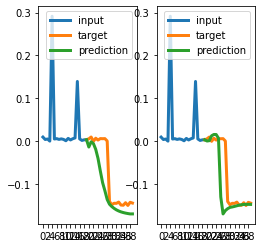

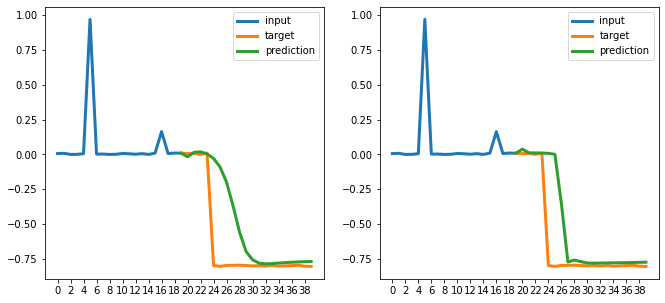

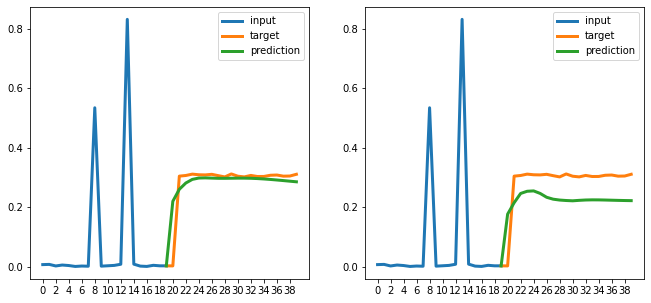

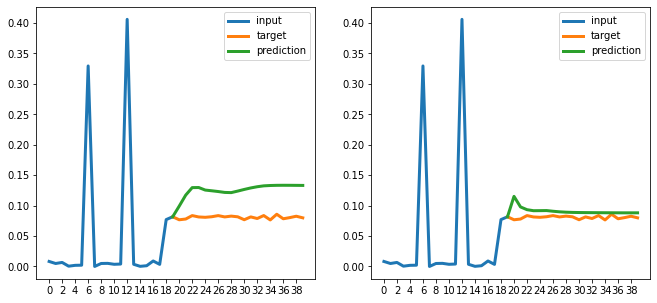

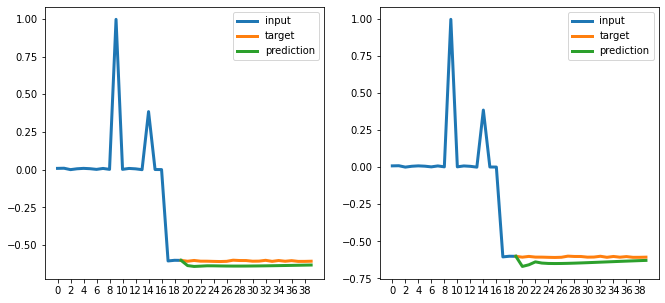

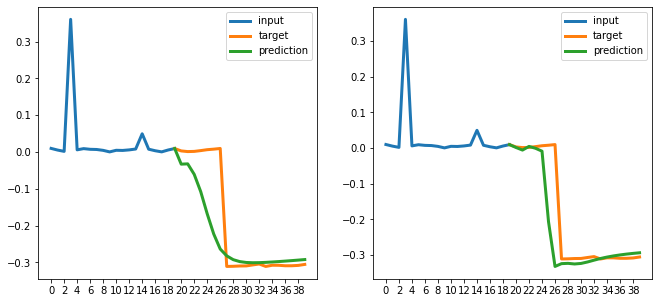

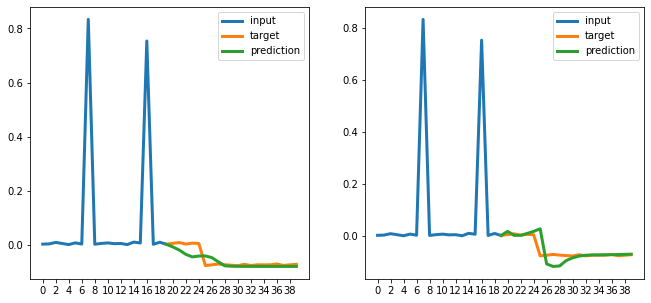

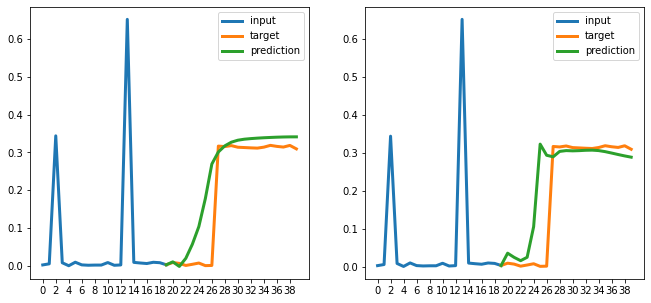

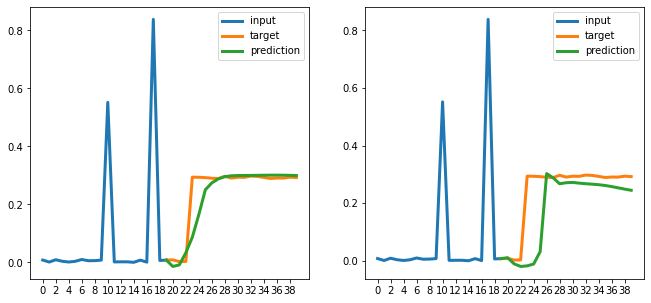

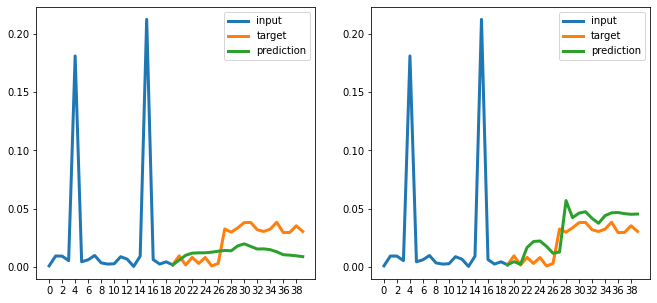

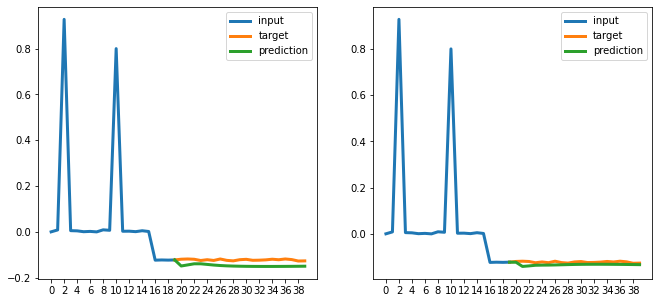

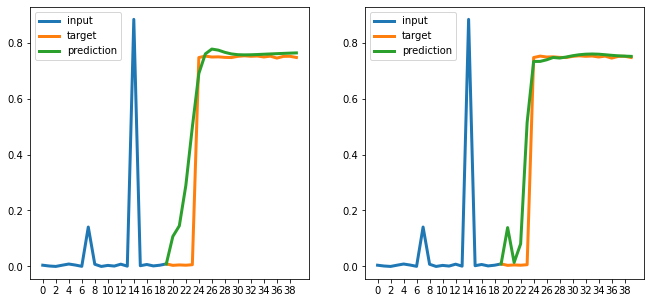

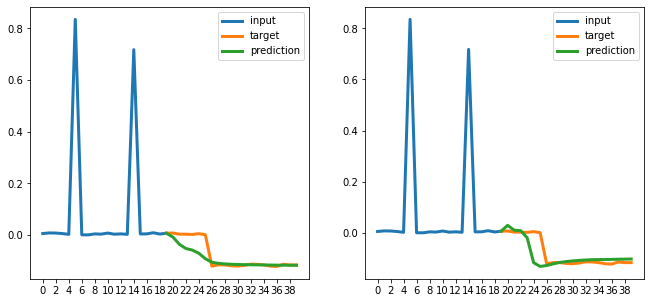

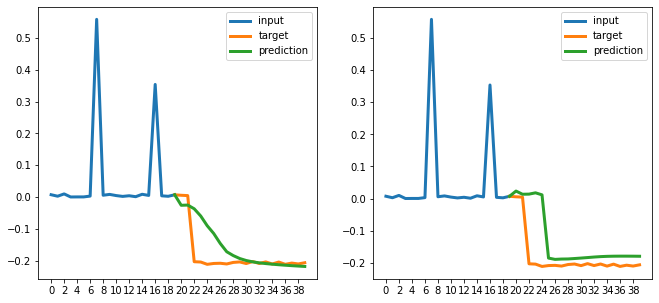

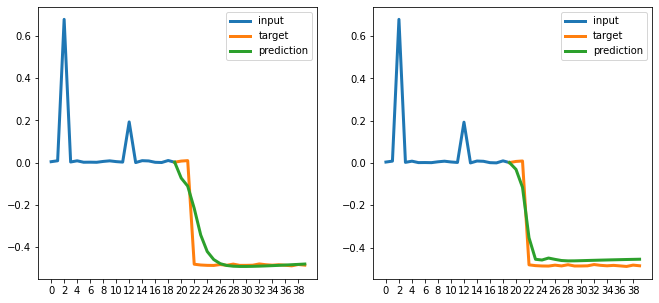

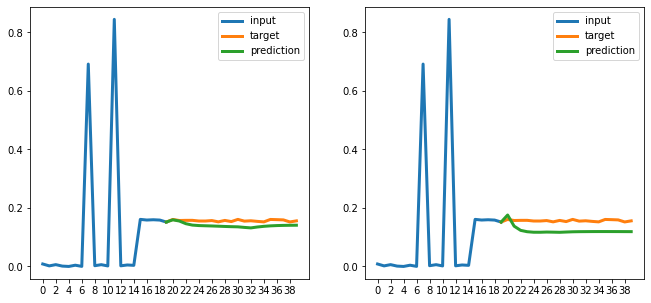

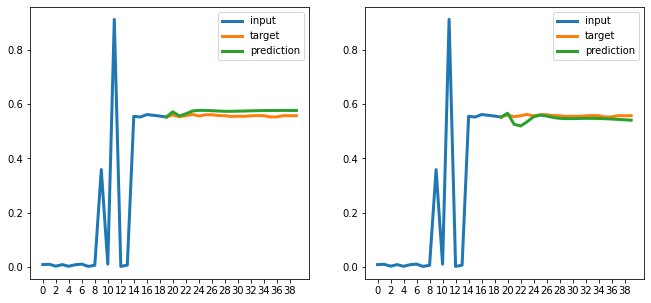

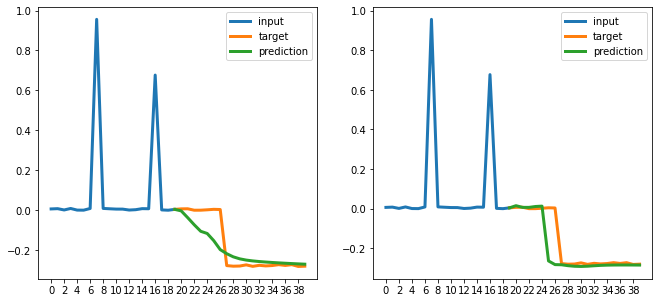

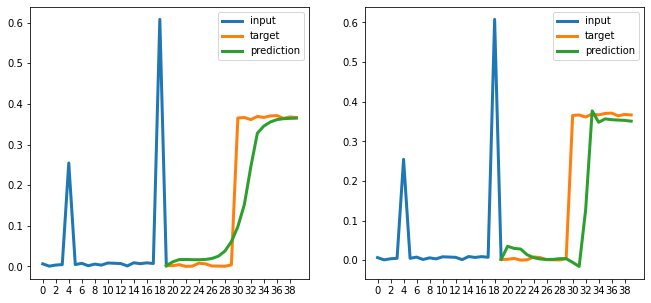

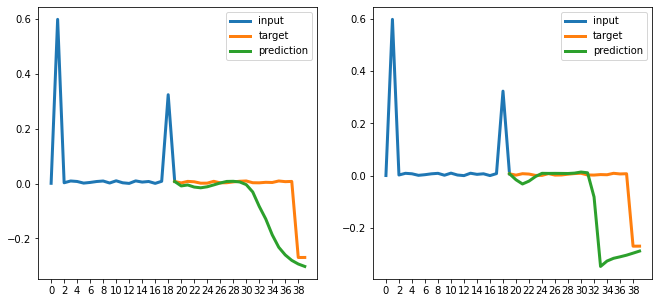

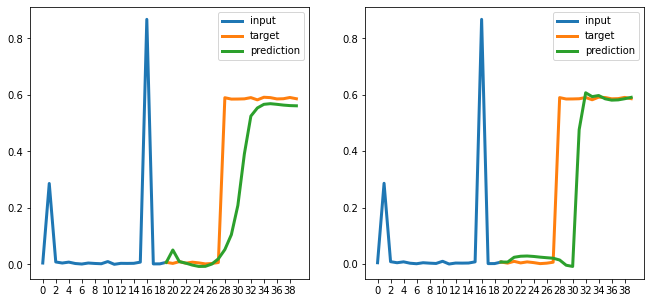

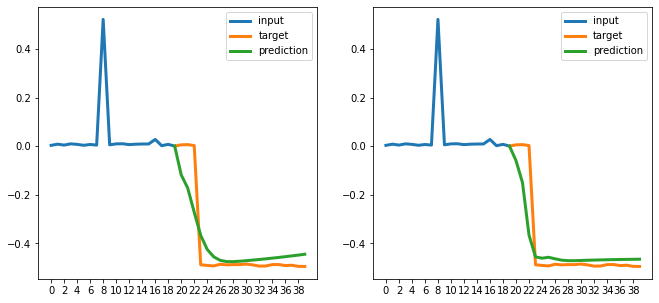

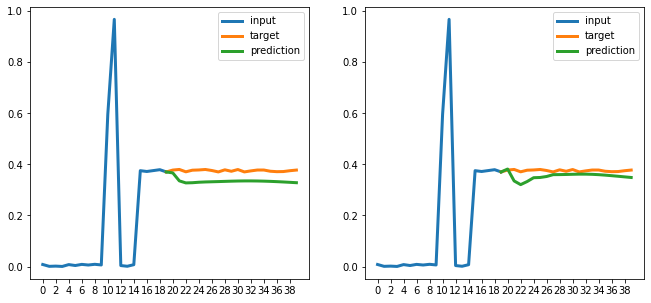

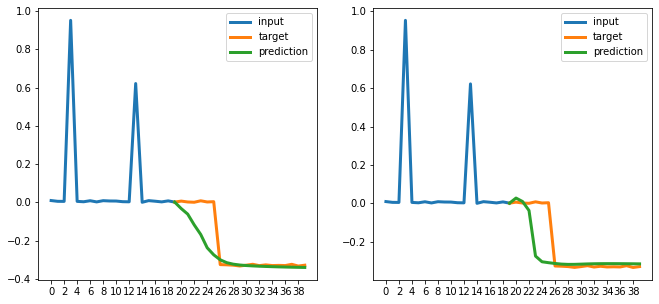

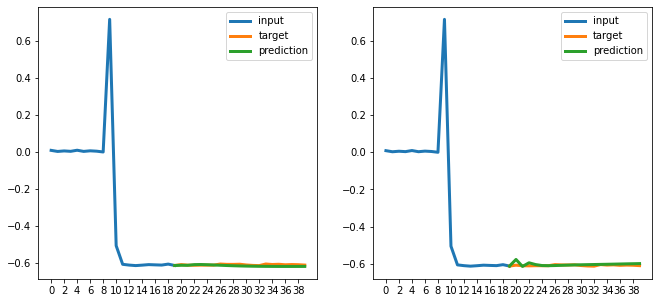

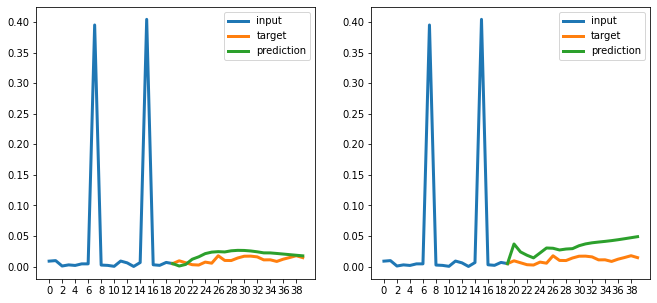

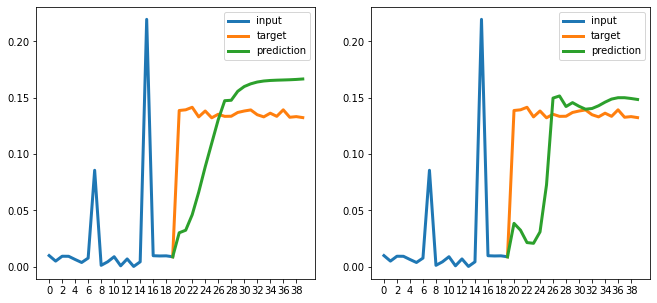

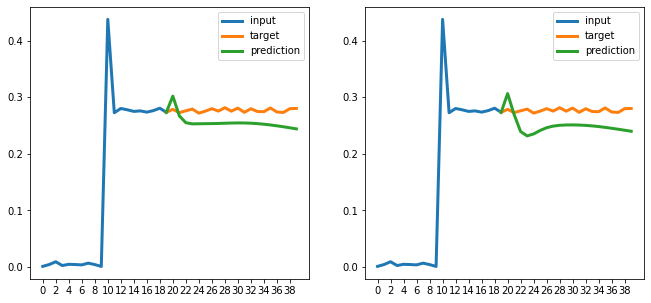

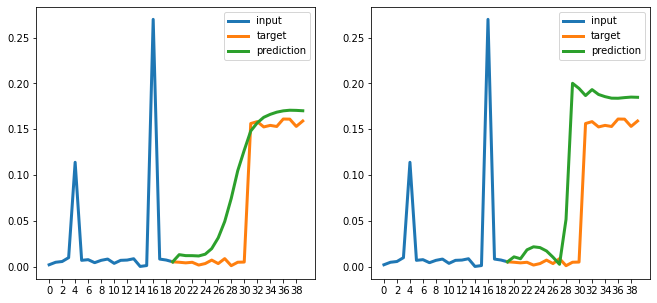

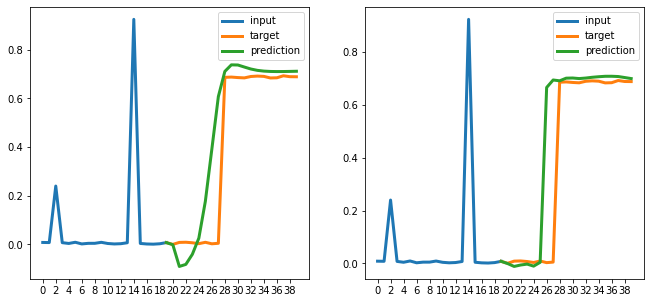

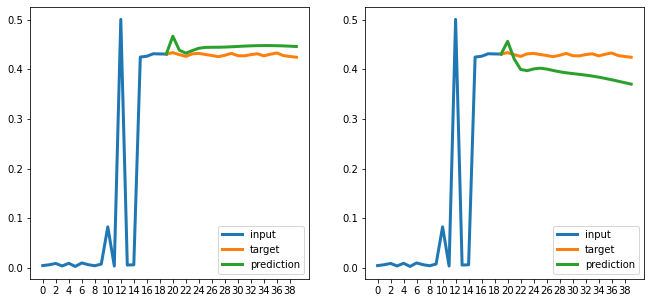

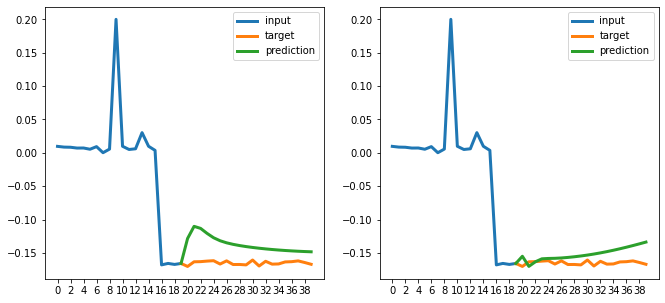

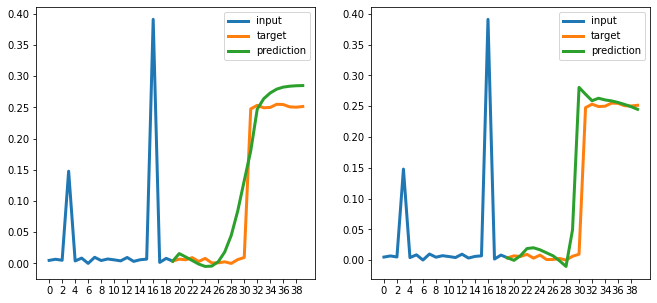

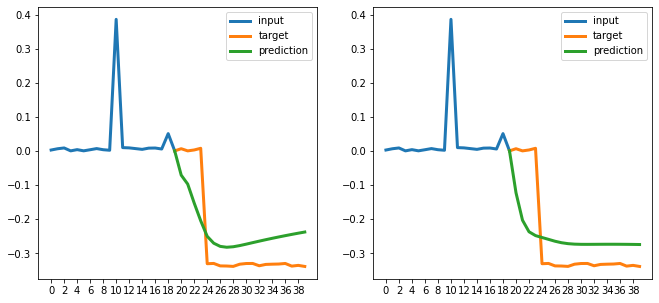

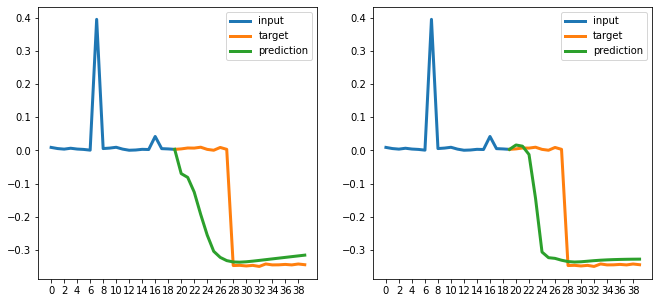

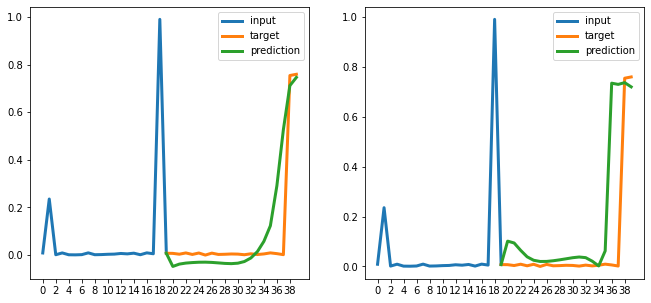

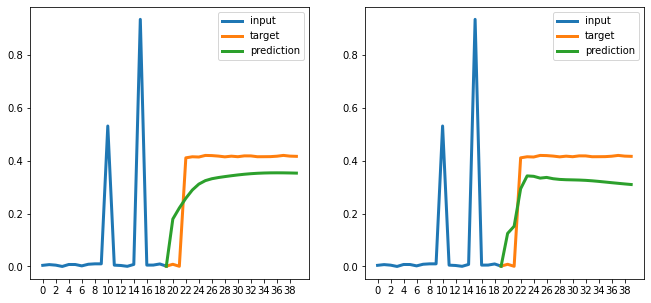

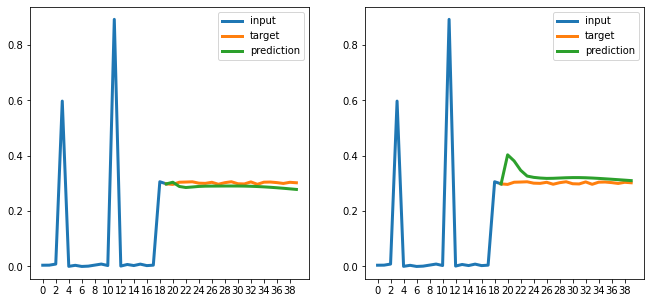

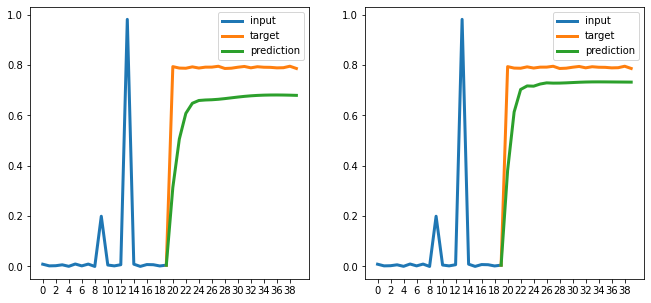

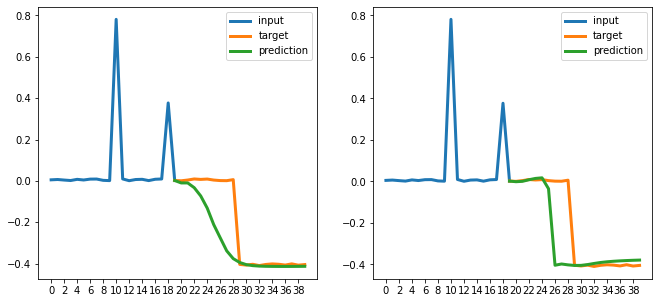

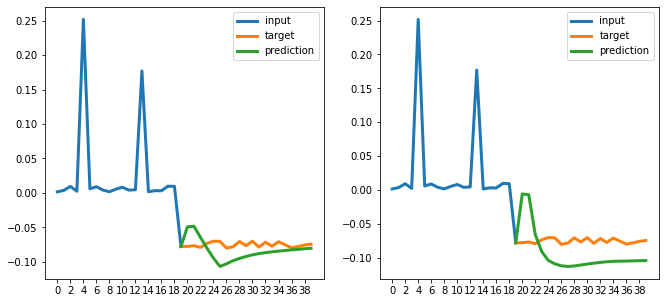

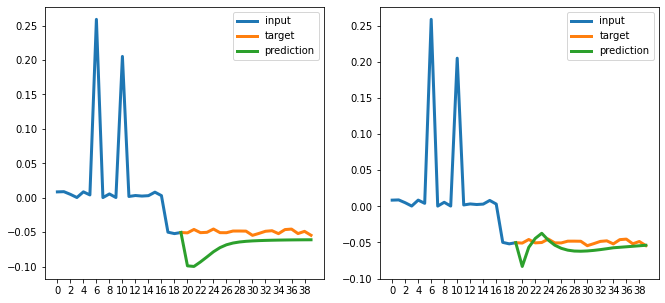

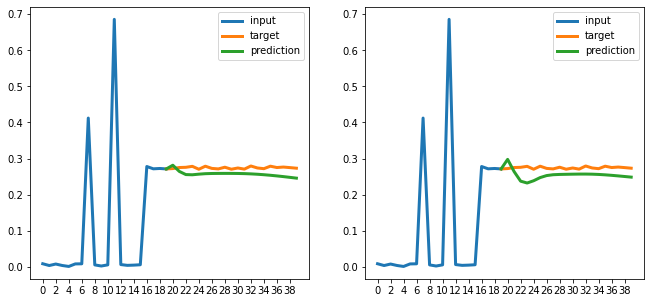

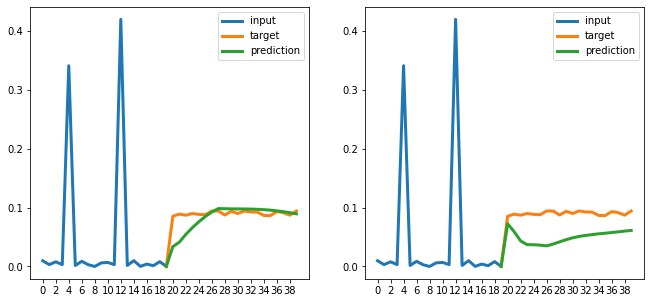

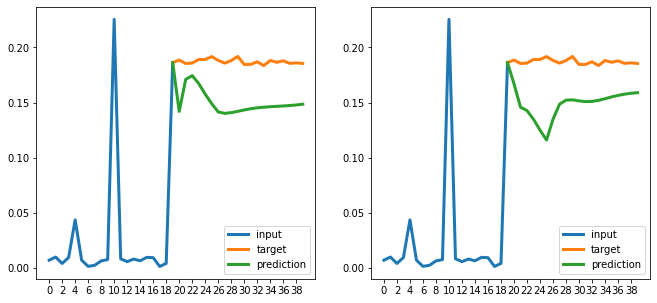

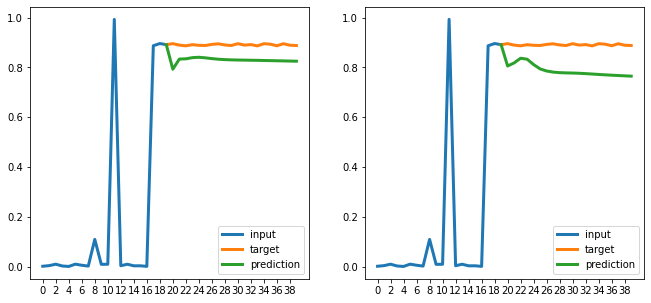

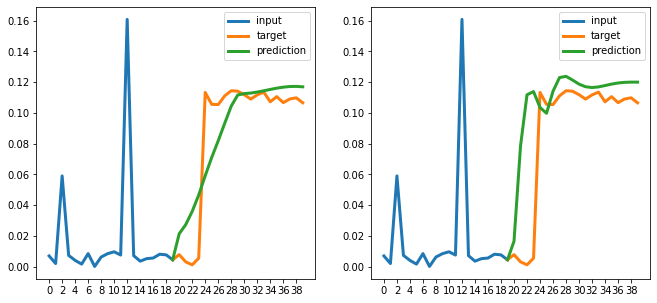

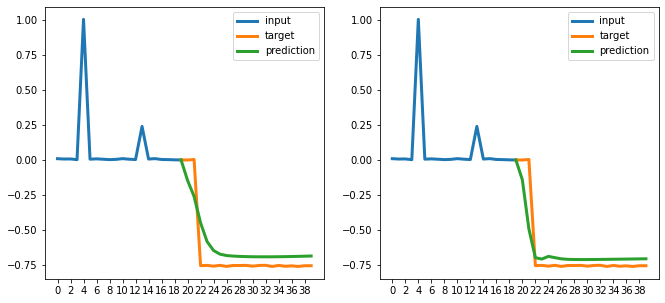

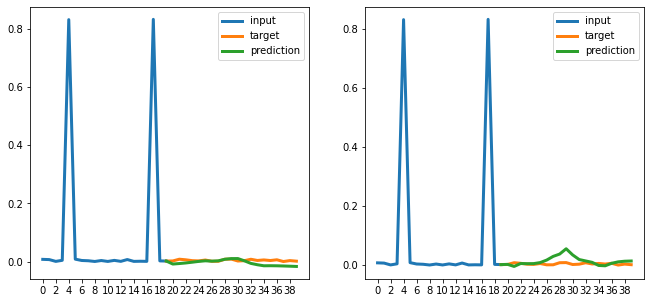

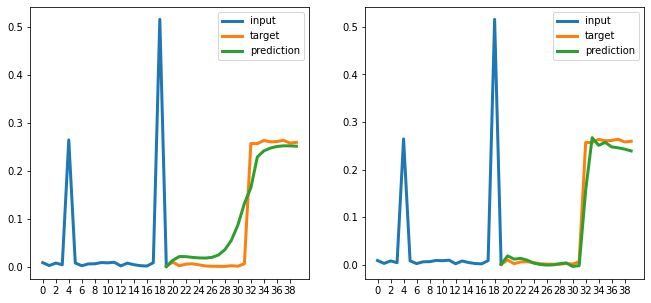

In [41]:
for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:] ##test_inputs Tensor with shape torch.Size([100, 20, 1])
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,40,2))
        plt.legend()
        k = k+1

    plt.show()

### Test shape

In [31]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device) 


In [35]:
test_print = torch.randn(100, 32, 1).to(device)

net_gru_dilate(test_print).shape #([100, 20, 1] B, pred_len, a variable to be prediction

torch.Size([100, 20, 1])

In [30]:
encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_dilate = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_dilate,loss_type='dilate',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

encoder = EncoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1, batch_size=batch_size).to(device)
decoder = DecoderRNN(input_size=1, hidden_size=128, num_grulstm_layers=1,fc_units=16, output_size=1).to(device)
net_gru_mse = Net_GRU(encoder,decoder, N_output, device).to(device)
train_model(net_gru_mse,loss_type='mse',learning_rate=0.001, epochs=500, gamma=gamma, print_every=50, eval_every=50,verbose=1)

# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse,net_gru_dilate]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,40,2))
        plt.legend()
        k = k+1

    plt.show()

epoch: 0, loss: 1.2078380584716797, loss shape: 2.1317954063415527, loss temporal: 0.2838808000087738
 Eval mse=  0.14047312140464782  dtw=  1.388190367870083  tdi=  0.03622499999999999


KeyboardInterrupt: ignored